# Apple Stock Price Prediction (AAPL)
This notebook predicts **next-day Adjusted Close** using classic ML regressors.

Key fixes:
- Time-series split (no random split)
- No backfill (prevents leakage)
- Features use only past information (shifted rolling stats)
- Clear target definition (next-day price)


## 1. Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math


## 2. Load data and inspect data

In [2]:
df = pd.read_csv("AppleStock.csv")

# Clean column names (some files contain non-breaking spaces)
df.columns = [c.strip().replace('\xa0','') for c in df.columns]

print(df.shape)
display(df.head())
print(df.columns)


(2727, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,23-Jan-15,28.08,28.44,27.88,28.25,25.05,"185,859,200"
1,26-Jan-15,28.43,28.59,28.20,28.27,25.07,"222,460,000"
2,27-Jan-15,28.1,28.12,27.26,27.28,24.20,"382,274,800"
3,28-Jan-15,29.41,29.53,28.83,28.83,25.56,"585,908,400"
4,29-Jan-15,29.08,29.80,28.89,29.73,26.36,"337,745,600"


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


## 3. Clean Data (nulls + duplicates)

In [3]:
# Parse date
df["Date"] = pd.to_datetime(df["Date"], format="%d-%b-%y", errors="coerce")

# Convert numeric columns
for col in ["Open", "High", "Low", "Close", "Adj Close"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Volume contains commas
df["Volume"] = pd.to_numeric(df["Volume"].astype(str).str.replace(",", "", regex=False), errors="coerce")

print("Missing values per column:")
print(df.isna().sum())

print("\nDuplicate rows:", df.duplicated().sum())

# Drop rows missing core fields (safe for time-series)
df = df.dropna(subset=["Date","Open","High","Low","Close","Adj Close","Volume"]).copy()

# Sort by date
df = df.sort_values("Date").reset_index(drop=True)

print("\nAfter cleaning:", df.shape)
display(df.head())


Missing values per column:
Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

Duplicate rows: 0

After cleaning: (2726, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-23,28.08,28.44,27.88,28.25,25.05,185859200.0
1,2015-01-26,28.43,28.59,28.20,28.27,25.07,222460000.0
2,2015-01-27,28.10,28.12,27.26,27.28,24.20,382274800.0
3,2015-01-28,29.41,29.53,28.83,28.83,25.56,585908400.0
4,2015-01-29,29.08,29.80,28.89,29.73,26.36,337745600.0


## 4. Analyze data with necessary figures

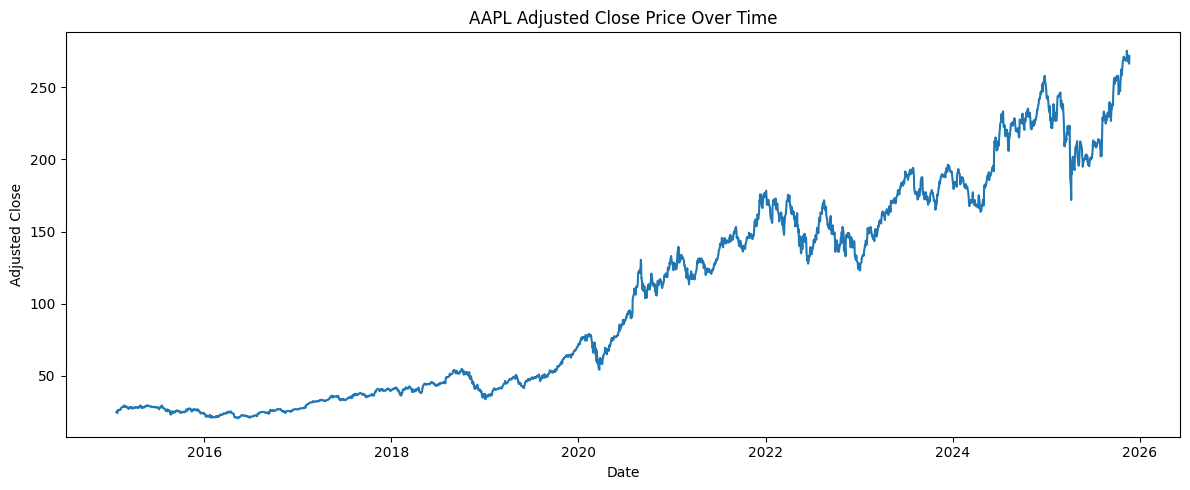

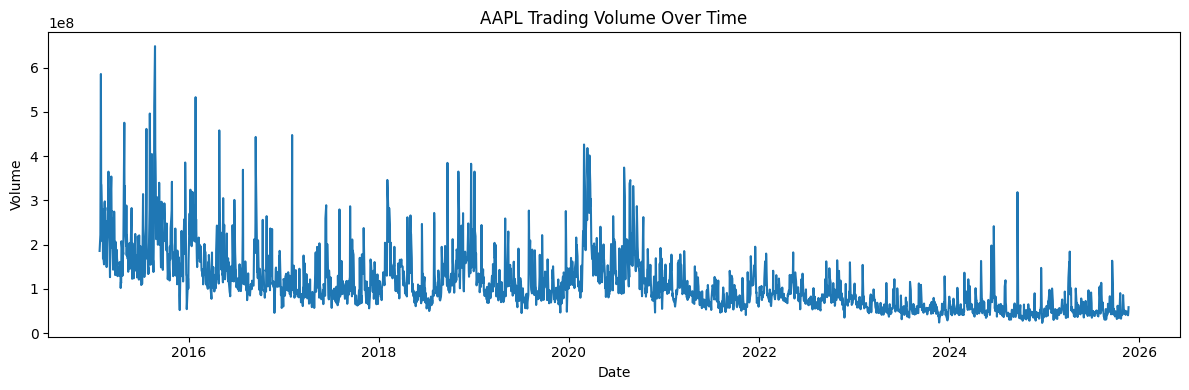

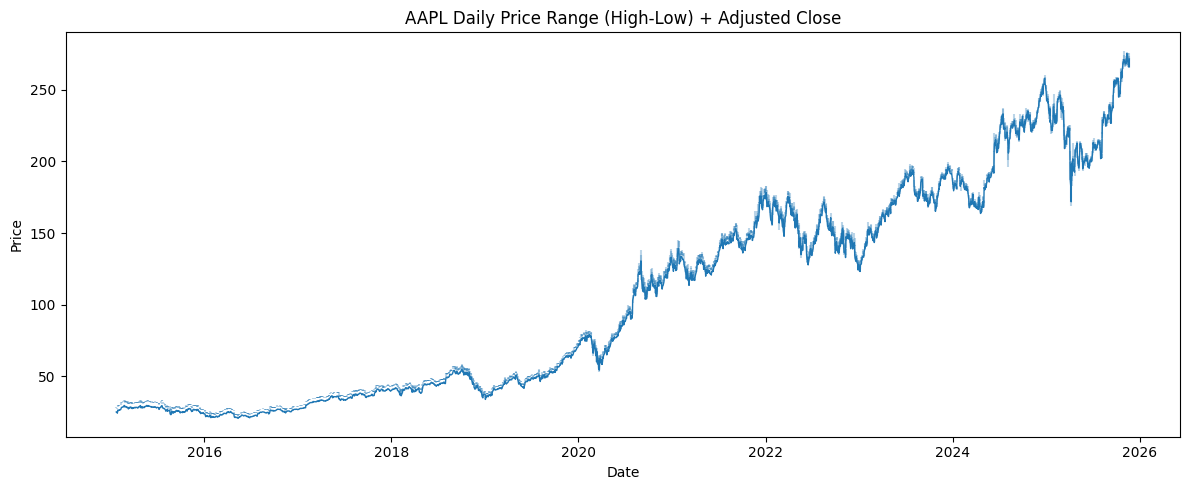

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Adj Close"])
plt.title("AAPL Adjusted Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["Volume"])
plt.title("AAPL Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))

# High-Low range as vertical lines
plt.vlines(df["Date"], df["Low"], df["High"], alpha=0.3)

# Adj Close as line
plt.plot(df["Date"], df["Adj Close"], linewidth=1)

plt.title("AAPL Daily Price Range (High-Low) + Adjusted Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


## 5. Prepare Target and features

In [5]:
data = df.copy()

# Returns
data["Return"] = data["Adj Close"].pct_change()
data["Lag1_Return"] = data["Return"].shift(1)
data["Lag2_Return"] = data["Return"].shift(2)

# Rolling statistics (shifted to avoid leakage)
for w in [5, 10, 20]:
    data[f"RollMean_{w}"] = data["Adj Close"].rolling(w).mean().shift(1)
    data[f"RollStd_{w}"]  = data["Adj Close"].rolling(w).std().shift(1)

# Target: next-day adjusted close
data["Target"] = data["Adj Close"].shift(-1)

# Drop rows with NaNs from rolling/shift
data = data.dropna().reset_index(drop=True)

feature_cols = [
    "Open","High","Low","Adj Close","Volume",
    "Lag1_Return","Lag2_Return",
    "RollMean_5","RollStd_5",
    "RollMean_10","RollStd_10",
    "RollMean_20","RollStd_20"
]

X = data[feature_cols].values
y = data["Target"].values

print("Dataset for modeling:", data.shape)
display(data[["Date","Adj Close","Target"]].head())


Dataset for modeling: (2705, 17)


,Date,Adj Close,Target
0,2015-02-23,29.60,29.42
1,2015-02-24,29.42,28.66
2,2015-02-25,28.66,29.03
3,2015-02-26,29.03,28.59
4,2015-02-27,28.59,28.73


## 6. Split data into training and testing sets (time-based 80/20)

In [6]:
split_idx = int(len(data) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_test = data["Date"].iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (2164, 13) Test size: (541, 13)


## 7. Train Linear Regression, KNN, SVR

In [7]:
models = {
    "Linear Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=10))
    ]),
    "SVR": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR(kernel="rbf", C=100, gamma="scale", epsilon=0.1))
    ])
}

preds = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds[name] = pipe.predict(X_test)

print("Training complete.")


Training complete.


## 8. Evaluate models (MAE, RMSE, R-squared)

In [8]:
results = []

for name, y_pred in preds.items():
    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(results, columns=["Model","MAE","RMSE","R2"]).sort_values("RMSE")
display(results_df)


,Model,MAE,RMSE,R2
0,Linear Regression,2.461742,3.660221,0.981984
1,KNN,34.291758,42.152512,-1.389377
2,SVR,41.489018,57.283031,-3.412551


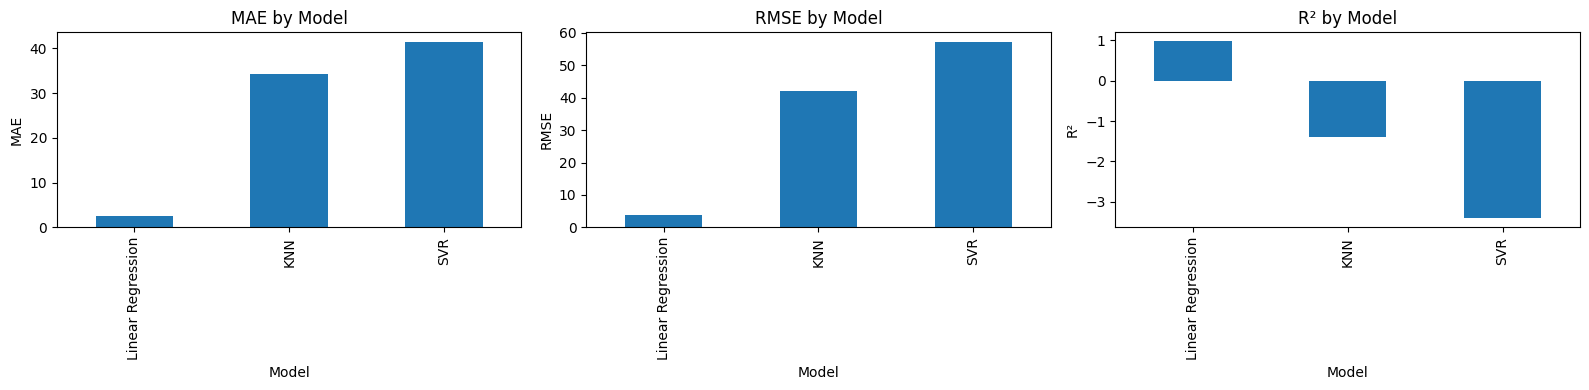

In [9]:
# ---- Extra Figure 1: Metrics comparison (MAE / RMSE / R2) ----
metrics_plot = results_df.set_index("Model")[["MAE", "RMSE", "R2"]]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

metrics_plot["MAE"].plot(kind="bar", ax=axes[0])
axes[0].set_title("MAE by Model")
axes[0].set_ylabel("MAE")

metrics_plot["RMSE"].plot(kind="bar", ax=axes[1])
axes[1].set_title("RMSE by Model")
axes[1].set_ylabel("RMSE")

metrics_plot["R2"].plot(kind="bar", ax=axes[2])
axes[2].set_title("R² by Model")
axes[2].set_ylabel("R²")

plt.tight_layout()
plt.show()


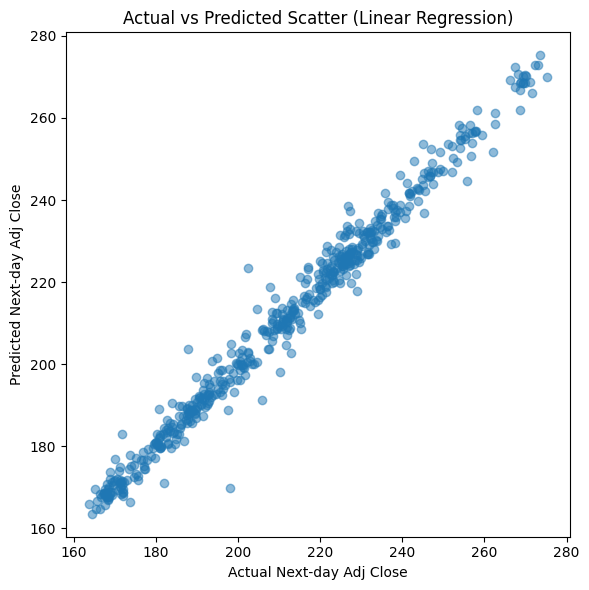

In [10]:
best_model_name = results_df.iloc[0]["Model"]
best_pred = preds[best_model_name]
residuals = y_test - best_pred

plt.figure(figsize=(6, 6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.title(f"Actual vs Predicted Scatter ({best_model_name})")
plt.xlabel("Actual Next-day Adj Close")
plt.ylabel("Predicted Next-day Adj Close")
plt.tight_layout()
plt.show()


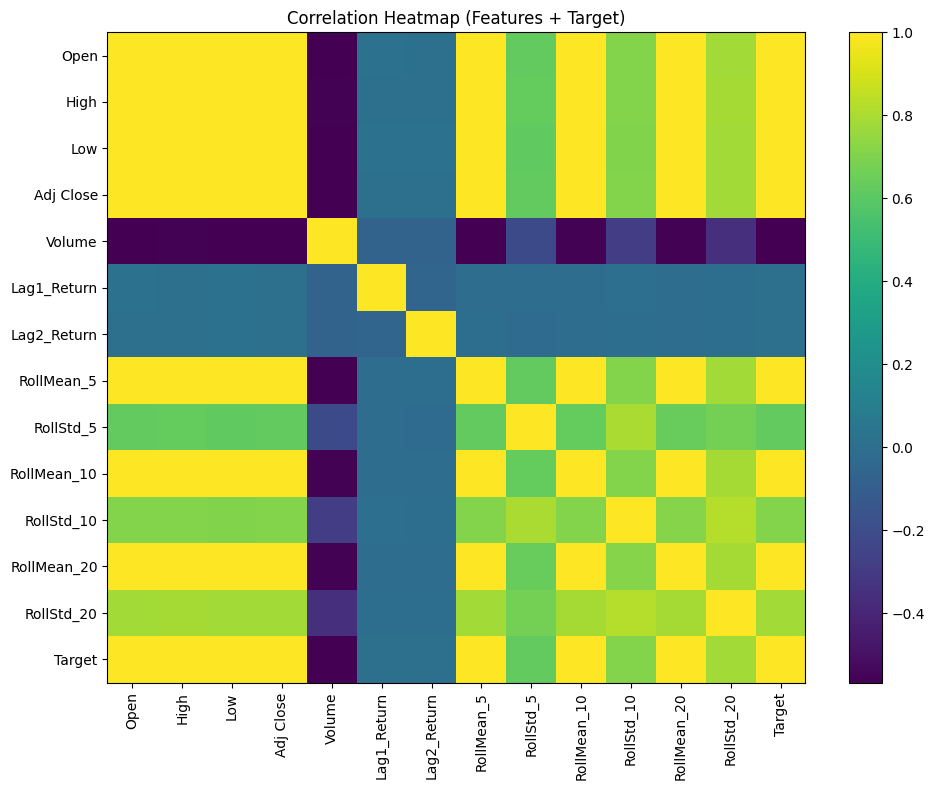

In [11]:
# ---- Extra Figure 6 (Optional): Feature correlation heatmap ----
corr = data[feature_cols + ["Target"]].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (Features + Target)")
plt.tight_layout()
plt.show()


## 9. Plot actual vs. predicted values

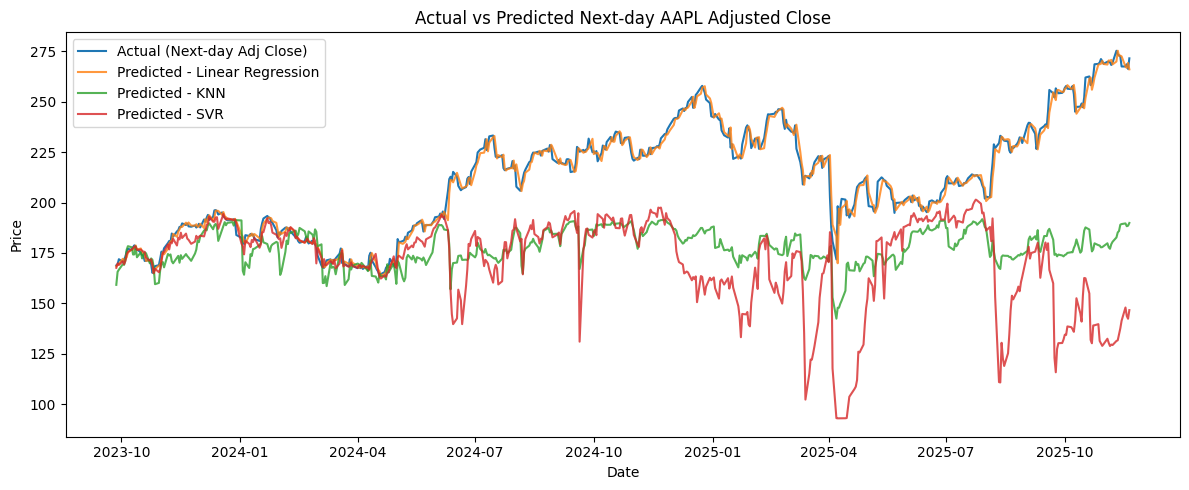

In [12]:
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test, label="Actual (Next-day Adj Close)")

for name, y_pred in preds.items():
    plt.plot(dates_test, y_pred, label=f"Predicted - {name}", alpha=0.8)

plt.title("Actual vs Predicted Next-day AAPL Adjusted Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


## 10. Predict future Apple stock prices (next 5 business days)
Recursive forecasting using the best RMSE model.

Note: future OHLCV values are unknown; this uses placeholders for demonstration.

In [13]:
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

# Train best model on ALL available labeled data
best_model.fit(X, y)

# Build the latest feature row from the LAST row of `data` (engineered + cleaned)
# `data` already has leakage-safe engineered features and no NaNs after dropna()
last_row = data.iloc[-1]

X_next = np.array([[last_row[c] for c in feature_cols]])
next_day_pred = best_model.predict(X_next)[0]

last_date = last_row["Date"]
next_trading_day = last_date + pd.tseries.offsets.BDay(1)

print("Best model:", best_model_name)
print("Last available date:", last_date.date())
print("Predicted next trading day:", next_trading_day.date())
print("Predicted next-day Adj Close:", float(next_day_pred))

Best model: Linear Regression
Last available date: 2025-11-20
Predicted next trading day: 2025-11-21
Predicted next-day Adj Close: 266.2608838898573
